# Detect handwritten digits using simple neural network

Given an image of a handwritten digit stored as pixel values, build a model that can correctly identify the digit. 

We are implementing the process described in Chapter 1 of the book "Introduction to Deep Learning" by Eugene Charniak. 


## 1. Data Preparation and Transformation

**1.1. Install Mnist dataset from Keras (http://yann.lecun.com/exdb/mnist/)** 

Input: each image of a digit is stored as 28 * 28 pixel values ranging from 0 to 255
Output: actual value of each image is stored as the digit itself with 10 possible outcomes {0,1,2,...8,9}

**1.2. Flatten input data** 

To simply the model, reshape two dimensional matrix (28 * 28) into one dimensional array (784 * 1)

**1.3. Normalize input data** 

divide each value in the input array by the maximum value in the input array so that the values range from 0 to 1

**1.4. Flatten output data** 

initialize the expected value as an array of 10 binary elements, 0 or 1 

We will build separate model for each possible outcome



In [1]:
# pip install keras tensorflow
from matplotlib import pyplot as plt
import numpy as np
import keras
from keras.datasets import mnist
import sklearn 
from sklearn import metrics
from collections import Counter 
import sys

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_validate, y_validate) = mnist.load_data()

In [3]:
x_train.shape

(60000, 28, 28)

In [4]:
def plt_digit(x_data):
    if x_data.shape[0] == 784:
        x_data = x_data.reshape(28,28)
    else:
        x_data = x_data
    plt.figure(figsize = (5,5))
    
    return plt.imshow(x_data,cmap="Greys")

Plot an Example of Input values


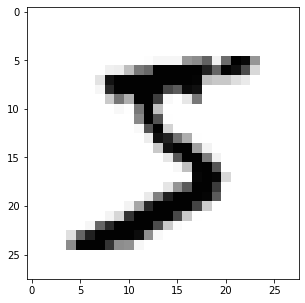

In [5]:
print("Plot an Example of Input values")
plt_digit(x_train[0])

In [6]:
y_train.shape

(60000,)

In [7]:
print("Example of Output value:")
y_train[0]

Example of Output value:


5

In [8]:
def normalize_x(x_data, size1, size2):
    new_data = x_data.reshape(size1, size2).astype('float32')
    new_data /= np.max(x_data) #255
    return new_data

x_train_updated = normalize_x(x_train, 60000, 784)
x_validate_updated = normalize_x(x_validate, 10000, 784)


def flatten_y(y_data):
    n_classes = len(Counter(y_data).keys()) 
    new_y_data = keras.utils.to_categorical(y_data, n_classes)
    return new_y_data

y_train_updated = flatten_y(y_train)
y_validate_updated = flatten_y(y_validate)


In [9]:
# check the number of occurances of each digits
def count_unique(data):
    unique, counts = np.unique(np.array(data), return_counts=True)
    return dict(zip(unique, counts))

In [10]:
print(count_unique(y_train))
print(count_unique(y_train_updated))

{0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}
{0.0: 540000, 1.0: 60000}


In [11]:
# just a sanity check
(x_train_updated[0] == x_train_updated[1]).all()

False

In [12]:
print("Example of Flattened Output values")
y_train_updated[0]

Example of Flattened Output values


array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [13]:
y_train[0]

5

## 2. Data Processing and Variables Initialization
    
**2.1. Split the data into batches** 

    60000 images into batch size of 100

add why?


**2.2. Initialize biases and weights** 

Randomly select values close to zero to prevent overflow in numpy package. If you select values close to 1 then logit becomes close to 1000, `e^1000` is too large for numpy to handle, so get infinity.
      
      number of biases = number of outputs = 10
      number of weights = number of outputs times number of inputs = 10 * 784
      
For a single batch size 100,  
100, 784 

**2.3. Calculate logit function**   

logit is a term for an un-normalized number that we are about to turn into probabilities using  softmax


      pre_logit = bias + sum(weight*input)
      number of logits for a single sample =  10
      Inputs for sample vary so logits for sample also vary
      number of logits for all sample =  10 * n_samples
      
      
      
**2.3. Calculate Softmax**

Activation function 

Convert the pre_logits (unnormalized numbers) into probabilities using softmax function
        pre_logit = {pre_logit_0, pre_logit_1,..., pre_logit_9}
        prob_j = exp(pre_logit_j)/exp(sum(pre_logit)
        where j is the jth element in pre_logit


**3.3. Compute Cross Entropy Loss Function**

Find the log probability of number using loss function

        loss_func_j = -log(prob_j)
    
   why, 
   
   
   stochastic gradient descent.

backward pass




add initial_bias in each element of 100 by 10 matrix




In [14]:
# Shuffle x and y at once with the same order
x_train_updated_shuff = x_train_updated[:]
y_train_updated_shuff = y_train_updated[:]
y_train_shuff = y_train[:]

import random

mapIndexPosition = list(zip(x_train_updated_shuff, y_train_updated_shuff, y_train_shuff))
random.Random(111).shuffle(mapIndexPosition)
x_train_updated_shuff, y_train_updated_shuff, y_train_shuff = zip(*mapIndexPosition)

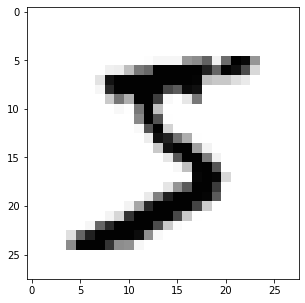

In [15]:
plt_digit(x_train_updated[0])

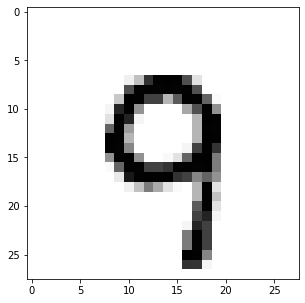

In [16]:
plt_digit(x_train_updated_shuff[0])

In [17]:
y_train_updated_shuff[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [18]:
y_train_shuff[0]

9

In [19]:
def split_batch(data, size):
    split_data= np.array([data[i:i + size] for i in range(0, len(data), size)], dtype=np.float128)
    return split_data

In [20]:
batch_size=100
batch_x = split_batch(x_train_updated_shuff, batch_size)
batch_y = split_batch(y_train_updated_shuff, batch_size)
batch_actual = split_batch(y_train_shuff, batch_size)

In [21]:
print(x_train_updated.shape)
print(batch_x.shape)

(60000, 784)
(600, 100, 784)


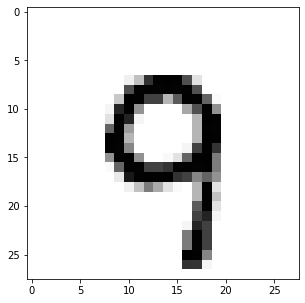

In [22]:
plt_digit(x_train_updated_shuff[0])

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Casting input data from 'float128' to 'float64' for imshow
  fig.canvas.print_figure(bytes_io, **kw)


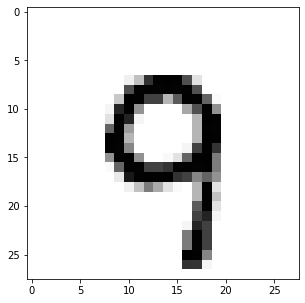

In [23]:
plt_digit(batch_x[0][0])

In [24]:
print(y_train_updated.shape)
print(batch_y.shape)
print(batch_actual.shape)

(60000, 10)
(600, 100, 10)
(600, 100)


In [25]:
y_train_updated_shuff[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [26]:
batch_y[0][0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float128)

In [27]:
y_train_shuff[0]

9

In [28]:
batch_actual[0][0]

9.0

In [29]:
n_train = x_train_updated.shape[0]
n_input = x_train_updated.shape[1]
n_output = y_train_updated.shape[1]
batch_size = 100
n_batch = round(len(x_train_updated)/batch_size)

print(n_train)
print(n_input)
print(n_output)
print(n_batch)

60000
784
10
600


## Backward Pass

For each batch (600 batches of size 100 each), take derivative of the loss with respect to bias then update bias by adding the sum of the derivative of biases to the initial bias. We have 100 by 10 biases. Now sum up the biases to obtain 10 biases. 

softmax_output = 100 by 10
dBias is sum columnwise to get 10 

updated_bias = initial_bias - learningrate * dBias
updated_bias = (10,) 


Similarly, take derivative of the loss with respect to weight and update the weights. We have 600 * 10 * 784 weights, sum up the weights to obtain 10 * 784 weights. 
softmax_output = 100 by 10
dloss_dlogit = 100 by 10

initial_weight = 784 by 10 
for single example: 
x = (784,)
dloss_dlogit = (10,) 
dloss_dweight = (784, 10)

for all example in the batch
sum up to get
x = (100, 784)
x_t = (784, 100)
dloss_dlogit = (100, 10) 
dloss_dweight = (100, 784, 10)

updated_weight = initial_weight - learningrate * dWeights
updated_weight = (784, 10)


For second batch, redo forward pass using the new set of biases and weights, then backward pass to obtain new bias and weight. use it for third batch and so on. 

One epoch, once we go through all training example, compute accuracy. 

shuffle the batches + ys and use parameters obtained from last batch as  

forward then backward until we get accuracy we want.



In [30]:
np.random.seed(1)

initial_b = np.random.uniform(0, 0.001, n_output)
print(initial_b.shape)
print(initial_b)

initial_w = np.random.uniform(0, 0.001, n_output*n_input).reshape(10,784)
print(initial_w.shape)
print(initial_w)


def forward_pass(data_x, bias_arr, weight_mat):
    Z = np.array([bias_arr[i] + np.sum(data_x*weight_mat[i], axis =1) for i in range(n_output)], dtype=np.float128) #np.transpose
    return Z

def softmax(Z):
    e_x = np.exp(np.transpose(Z))
    S = np.array([e_x[i]/np.sum(e_x[i]) for i in range(e_x.shape[0])]) #e_x / np.sum(e_x)  
    return S  

def cross_entropy(data_y, data_y_pred):
    pred_y = get_max_index(data_y_pred)
    return -np.log(data)

def get_max_index(data):
    n_j = data.shape[0]
    n_i = data.shape[1]
    lst = np.array([list(data[j]).index(max(data[j])) for j in range(n_j)])
    return lst

def check_accuracy(predicted, expected):
    batch_acc = sklearn.metrics.accuracy_score(predicted, expected)
    return batch_acc

def deriv_logit(actual, data):
    lr_deriv_loss_lst = []
    n_output = 10
    for i in range(n_output):
        lr_deriv_loss_lst.append(i)
        prob_i = data[i]   
        if actual == i:
            lr_deriv_loss_lst[i] = 1- prob_i
        else:
            lr_deriv_loss_lst[i] = prob_i
    return lr_deriv_loss_lst

lr = 0.001

(10,)
[4.17022005e-04 7.20324493e-04 1.14374817e-07 3.02332573e-04
 1.46755891e-04 9.23385948e-05 1.86260211e-04 3.45560727e-04
 3.96767474e-04 5.38816734e-04]
(10, 784)
[[4.19194514e-04 6.85219500e-04 2.04452250e-04 ... 3.57511167e-04
  3.30276937e-04 6.97368876e-04]
 [2.68650124e-04 8.08278014e-04 2.95288794e-04 ... 7.65183957e-04
  5.68152543e-04 6.66188090e-04]
 [1.07813901e-04 8.42830514e-05 6.25121068e-04 ... 5.73561083e-04
  9.05377380e-04 3.47413933e-04]
 ...
 [2.10073853e-04 2.26801116e-04 4.57388676e-04 ... 4.69515750e-04
  3.84104101e-04 6.75198447e-04]
 [9.53945889e-05 1.61804875e-04 9.69143921e-04 ... 1.88520463e-05
  4.72346213e-04 9.38995130e-04]
 [3.25574819e-04 3.22153019e-04 5.20307238e-05 ... 2.47718753e-04
  1.23078052e-04 1.26350470e-04]]


In [31]:
lr = 0.1


#### Different results !!

## First Batch 

In [37]:
Zs_0 = forward_pass(batch_x[0], initial_b, initial_w) 
Ss_0 = softmax(Zs_0) 
pred_ys_0 = get_max_index(Ss_0)

print("Accuracy is ", check_accuracy(pred_ys_0, batch_actual[0]))
print(pred_ys_0)
print(batch_actual[0])

dLs_0 = np.array([deriv_logit(batch_actual[0][j], Ss_0[j]) for j in range(Ss_0.shape[0])])
sum_dBs_0 = np.sum(dLs_0, axis = 0)
updated_bias_0 = initial_b - lr*sum_dBs_0
print("Initial biases are \n", initial_b)
print("Updated biases are \n", updated_bias_0)


sum_dWs_0 = np.sum(np.array([np.outer(dLs_0[i], batch_x[0][i]) for i in range(dLs_0.shape[0])]), axis = 0)
#sum_dWs_0 = np.sum(np.array([np.outer(dLs_0, batch_x[0])]), axis = 0)
updated_weights_0 = initial_w -lr*sum_dWs_0
print("Initial weights are \n", initial_w[0])
print("Updated weights are \n", updated_weights_0[0])
#print("Check if initial weights equal to updated weights: ", all(initial_w[0] == updated_weights[0]))


Accuracy is  0.08
[7 6 0 6 2 0 0 2 2 0 2 2 7 2 1 2 7 0 7 1 6 7 0 2 1 2 2 2 4 1 0 7 6 4 4 0 6
 0 1 6 0 2 0 7 2 2 0 7 7 2 2 6 0 4 0 6 8 0 0 0 0 0 2 2 7 1 0 7 2 7 2 4 4 1
 2 0 7 2 0 2 1 7 7 6 6 7 7 1 4 6 2 0 1 0 2 0 0 2 7 2]
[9. 6. 6. 6. 0. 0. 6. 8. 9. 8. 3. 3. 6. 0. 2. 9. 2. 2. 1. 7. 0. 0. 5. 1.
 5. 8. 3. 4. 5. 2. 6. 5. 5. 7. 3. 4. 2. 4. 6. 3. 4. 8. 2. 9. 7. 1. 9. 8.
 5. 0. 2. 7. 7. 7. 4. 1. 1. 5. 0. 5. 5. 8. 3. 0. 1. 6. 5. 1. 0. 1. 3. 7.
 5. 6. 1. 5. 1. 0. 5. 7. 6. 9. 1. 1. 6. 5. 9. 6. 9. 6. 8. 2. 9. 5. 0. 8.
 0. 0. 5. 7.]
Initial biases are 
 [4.17022005e-04 7.20324493e-04 1.14374817e-07 3.02332573e-04
 1.46755891e-04 9.23385948e-05 1.86260211e-04 3.45560727e-04
 3.96767474e-04 5.38816734e-04]
Updated biases are 
 [-2.0404271  -1.95977218 -1.6416114  -1.55802099 -1.3994152  -2.2787739
 -2.03980161 -1.7209771  -1.63863147 -1.71862089]
Initial weights are 
 [4.19194514e-04 6.85219500e-04 2.04452250e-04 8.78117436e-04
 2.73875932e-05 6.70467510e-04 4.17304802e-04 5.58689828e-04
 1.4038693

In [38]:
initial_w.shape

(10, 784)

In [39]:
sum_dWs_0.shape

(10, 784)

In [40]:
updated_weights_0.shape

(10, 784)

## Second Batch

In [41]:
Zs_1 = forward_pass(batch_x[1], updated_bias_0, updated_weights_0) 
Ss_1 = softmax(Zs_1) 
pred_ys_1 = get_max_index(Ss_1)

print("Accuracy is ", check_accuracy(pred_ys_1, batch_actual[1]))
print(pred_ys_1)
print(batch_actual[0])

dLs_1 = np.array([deriv_logit(batch_actual[1][j], Ss_1[j]) for j in range(Ss_1.shape[0])])
sum_dBs_1 = np.sum(dLs_1, axis = 0)
updated_bias_1 = initial_b - lr*sum_dBs_1
print("Initial biases are \n", updated_bias_0)
print("Updated biases are \n", updated_bias_1)


sum_dWs_1 = np.sum(np.array([np.outer(dLs_1[i], batch_x[1][i]) for i in range(dLs_1.shape[0])]), axis = 0)
updated_weights_1 = initial_w -lr*sum_dWs_1
print("Initial weights are \n", updated_weights_0[0])
print("Updated weights are \n", updated_weights_1[0])
#print("Check if initial weights equal to updated weights: ", all(initial_w[0] == updated_weights[0]))


Accuracy is  0.08
[4 4 4 4 4 4 4 1 4 4 4 4 1 4 4 4 4 4 3 4 4 4 1 4 4 4 3 4 4 4 4 4 4 4 4 4 4
 4 1 4 4 4 4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4 4 4 4 4 4 4 4 4 3 4 4 4
 4 3 1 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 1]
[9. 6. 6. 6. 0. 0. 6. 8. 9. 8. 3. 3. 6. 0. 2. 9. 2. 2. 1. 7. 0. 0. 5. 1.
 5. 8. 3. 4. 5. 2. 6. 5. 5. 7. 3. 4. 2. 4. 6. 3. 4. 8. 2. 9. 7. 1. 9. 8.
 5. 0. 2. 7. 7. 7. 4. 1. 1. 5. 0. 5. 5. 8. 3. 0. 1. 6. 5. 1. 0. 1. 3. 7.
 5. 6. 1. 5. 1. 0. 5. 7. 6. 9. 1. 1. 6. 5. 9. 6. 9. 6. 8. 2. 9. 5. 0. 8.
 0. 0. 5. 7.]
Initial biases are 
 [-2.0404271  -1.95977218 -1.6416114  -1.55802099 -1.3994152  -2.2787739
 -2.03980161 -1.7209771  -1.63863147 -1.71862089]
Updated biases are 
 [-1.09959904 -1.94964686 -1.03678578 -1.71228935 -8.56316088 -0.7999081
 -0.69994601 -1.1002523  -0.89994938 -0.60372292]
Initial weights are 
 [ 4.19194514e-04  6.85219500e-04  2.04452250e-04  8.78117436e-04
  2.73875932e-05  6.70467510e-04  4.17304802e-04  5.58689828e-04
  1.40386939e-04  1.98101489e-04  

In [42]:
for n_epoch in range(3):
    l_pred = []
    print("Epoch ", n_epoch+1)
    for n_batch in range(batch_x.shape[0]):
        Zs = forward_pass(batch_x[n_batch], initial_b, initial_w) 
        Ss = softmax(Zs) 
        
        #for i in range(batch_size)])
        #print(np.sum(Ss, axis = 1)) 
        #print("Dimension of softmax output for all examples in a single batch is ", Ss.shape)
        #print(Ss)

        pred_ys = get_max_index(Ss)
        l_pred.append(pred_ys)

        #print("Dimension of predicted output for all examples in a single batch is ", pred_ys.shape)
        print("Accuracy is ", check_accuracy(pred_ys, batch_actual[n_batch]))
        print(pred_ys)
        print(batch_actual[n_batch])
        # single example
        # dLs = deriv_logit(batch_actual[0][0], Ss[0])
        # all examples in the first batch (batch_actual[0])
        # j is the jth training example in the first batch

        dLs = np.array([deriv_logit(batch_actual[n_batch][j], Ss[j]) for j in range(Ss.shape[0])])
        #print(batch_actual[n_batch][0])
        #dLs_flat = dLs.flatten()
        #print(np.all(dLs_flat <= 1)) #range(Ss.shape[0])))
        #print("Dimension of derivative wrt logits for all examples in a single batch is ", dLs.shape)
        #print(batch_actual[i].shape)
        
        # single example
        #dBs = -lr*dLs[0]
        # all examples
        sum_dBs = np.sum(dLs, axis = 0)
        #print(sum_dBs)
        #dBs = -lr*dLs
        #sum_dBs = np.sum(dBs, axis = 0)
        
        #print("Dimension of derivative wrt biases for all examples in a single batch is ", dBs.shape)
        #print("Dimension of sum of dBs columnwise for all examples in a single batch is ", sum_dBs.shape)

        updated_bias = initial_b - lr*sum_dBs
        print("Initial biases are \n", initial_b)
        print("Updated biases are \n", updated_bias)
    

        sum_dWs = np.sum(np.array([np.outer(dLs[i], batch_x[n_batch][i]) for i in range(dLs.shape[0])]), axis = 0)
        #np.transpose(dLs).dot(batch_x[n_batch])
        #print("Dimension of initial weights is ", initial_w.shape)
        #print("Dimension of sum of dWs columnwise for all examples in a single batch is ", sum_dWs.shape)
        
        updated_weights = initial_w -lr*sum_dWs
        #print("Initial weights are \n", initial_w[0])
        #print("Updated weights are \n", updated_weights[0])
        #print("Check if initial weights equal to updated weights: ", all(initial_w[0] == updated_weights[0]))
        
        #np.sum(np.transpose(dLs).dot(batch_x[0]), axis = 0)
        #np.array([np.sum(batch_x[i]*dLs[n_sample][n_out], axis = 1) for n_sample in range(batch_x[i].shape[0]) for n_out in range(n_output)])
        #np.transpose(batch_x[i]).dot(dLs) 
        #np.transpose(batch_x[i])*dLs 
        #print(np.mat(np.transpose(batch_x[i])) * np.mat(dLs))

        initial_b = updated_bias
        initial_w = updated_weights
    if n_batch == 600-1:
        print("Final accuracy is", check_accuracy(np.array(l_pred).flatten(), batch_actual.flatten()))

Epoch  1
Accuracy is  0.08
[7 6 0 6 2 0 0 2 2 0 2 2 7 2 1 2 7 0 7 1 6 7 0 2 1 2 2 2 4 1 0 7 6 4 4 0 6
 0 1 6 0 2 0 7 2 2 0 7 7 2 2 6 0 4 0 6 8 0 0 0 0 0 2 2 7 1 0 7 2 7 2 4 4 1
 2 0 7 2 0 2 1 7 7 6 6 7 7 1 4 6 2 0 1 0 2 0 0 2 7 2]
[9. 6. 6. 6. 0. 0. 6. 8. 9. 8. 3. 3. 6. 0. 2. 9. 2. 2. 1. 7. 0. 0. 5. 1.
 5. 8. 3. 4. 5. 2. 6. 5. 5. 7. 3. 4. 2. 4. 6. 3. 4. 8. 2. 9. 7. 1. 9. 8.
 5. 0. 2. 7. 7. 7. 4. 1. 1. 5. 0. 5. 5. 8. 3. 0. 1. 6. 5. 1. 0. 1. 3. 7.
 5. 6. 1. 5. 1. 0. 5. 7. 6. 9. 1. 1. 6. 5. 9. 6. 9. 6. 8. 2. 9. 5. 0. 8.
 0. 0. 5. 7.]
Initial biases are 
 [4.17022005e-04 7.20324493e-04 1.14374817e-07 3.02332573e-04
 1.46755891e-04 9.23385948e-05 1.86260211e-04 3.45560727e-04
 3.96767474e-04 5.38816734e-04]
Updated biases are 
 [-2.0404271  -1.95977218 -1.6416114  -1.55802099 -1.3994152  -2.2787739
 -2.03980161 -1.7209771  -1.63863147 -1.71862089]
Accuracy is  0.08
[4 4 4 4 4 4 4 1 4 4 4 4 1 4 4 4 4 4 3 4 4 4 1 4 4 4 3 4 4 4 4 4 4 4 4 4 4
 4 1 4 4 4 4 4 4 4 3 4 4 4 4 4 4 4 4 4 4 4 4 4 3 4 4

Accuracy is  0.0
[2 2 7 2 7 0 2 0 2 2 2 0 7 2 7 7 2 2 2 2 2 7 2 2 7 2 2 2 1 7 2 0 1 2 7 7 2
 7 7 2 1 1 1 2 2 1 2 1 7 0 0 7 0 7 7 2 1 1 2 1 7 7 1 7 0 1 1 7 2 7 7 2 2 1
 7 7 7 1 7 1 1 7 7 2 7 2 7 2 0 7 1 7 7 7 7 2 7 1 1 7]
[5. 9. 1. 7. 6. 3. 1. 1. 9. 5. 4. 1. 6. 7. 2. 2. 9. 1. 7. 9. 7. 2. 8. 9.
 0. 4. 0. 0. 4. 6. 9. 7. 4. 9. 2. 8. 1. 8. 3. 8. 7. 7. 7. 5. 7. 7. 4. 2.
 5. 2. 1. 6. 1. 0. 2. 3. 0. 9. 1. 7. 1. 2. 7. 5. 1. 2. 7. 5. 3. 2. 3. 5.
 5. 4. 1. 0. 2. 4. 8. 7. 7. 6. 6. 9. 8. 0. 1. 9. 1. 3. 0. 0. 6. 3. 2. 3.
 5. 2. 4. 6.]
Initial biases are 
 [-20.90474822 -23.2489262  -19.52517528 -21.57443971 -23.02091551
 -20.71715006 -22.36143008 -21.10274326 -19.78068745 -21.87499043]
Updated biases are 
 [-22.81707986 -26.67486202 -24.19084785 -22.3744421  -23.82091551
 -21.61715277 -23.16143008 -26.1987981  -20.38068748 -22.87499043]
Accuracy is  0.0
[0 1 0 8 8 0 8 5 5 3 0 0 5 5 8 5 5 0 3 5 5 3 8 5 1 8 8 6 5 5 9 5 5 8 5 8 1
 8 8 5 5 8 8 5 1 1 3 3 8 8 0 1 5 5 1 6 1 3 0 5 5 5 5 5 1 5 8 8 4 9 0 0 0 

Accuracy is  0.0
[2 2 4 2 0 2 4 3 2 6 4 0 2 7 7 3 3 0 1 4 2 3 1 7 8 0 4 0 2 0 3 8 8 1 2 1 1
 4 8 8 2 0 1 6 2 3 4 4 2 1 0 1 3 4 7 4 8 8 4 4 1 4 4 0 4 2 7 1 4 7 2 4 7 7
 2 6 3 3 7 4 2 4 0 8 1 6 4 4 7 9 1 3 8 7 1 3 7 4 7 7]
[9. 6. 2. 7. 1. 5. 1. 7. 9. 5. 2. 4. 7. 1. 3. 2. 0. 1. 5. 2. 3. 6. 4. 6.
 9. 3. 7. 7. 7. 1. 4. 4. 7. 9. 9. 7. 0. 5. 4. 6. 5. 9. 0. 3. 5. 4. 0. 2.
 9. 9. 4. 0. 4. 0. 0. 5. 0. 7. 1. 8. 3. 1. 0. 8. 3. 5. 6. 0. 0. 0. 3. 0.
 8. 3. 9. 0. 9. 4. 6. 2. 9. 1. 4. 6. 7. 5. 0. 7. 8. 0. 0. 8. 9. 3. 4. 4.
 4. 1. 6. 3.]
Initial biases are 
 [-44.64775289 -49.25251076 -41.71232853 -41.30038123 -43.2643594
 -43.71703028 -42.73888685 -44.39877121 -39.15689531 -42.75891071]
Updated biases are 
 [-47.35888145 -51.47400353 -43.87244906 -43.4173967  -46.7582121
 -44.61703028 -43.94952227 -46.8597197  -40.58169274 -44.05891933]
Accuracy is  0.0
[7 3 6 9 3 7 6 9 2 9 9 8 6 9 6 9 3 8 1 7 3 1 9 2 6 6 8 7 7 9 8 1 2 8 9 6 6
 1 8 6 7 3 9 2 9 2 1 9 9 3 8 6 6 6 1 1 8 1 9 8 3 6 9 9 9 8 6 6 2 6 6 9 6 3


Accuracy is  0.0
[6 6 6 1 6 4 3 6 0 7 3 8 1 6 1 4 4 4 0 1 6 6 4 6 6 6 6 3 3 6 6 1 4 0 1 0 7
 6 0 7 6 1 3 4 6 8 7 7 6 1 6 3 6 7 6 7 6 2 0 4 7 7 1 4 4 7 6 6 6 1 6 4 3 6
 6 6 6 7 7 6 4 4 6 6 8 6 7 6 6 6 4 7 6 5 6 4 4 7 7 6]
[7. 5. 7. 7. 3. 0. 4. 3. 1. 6. 9. 6. 4. 9. 9. 3. 8. 1. 8. 6. 3. 7. 3. 8.
 3. 2. 8. 7. 6. 3. 3. 4. 2. 4. 0. 6. 1. 8. 4. 5. 9. 6. 2. 3. 5. 2. 2. 0.
 1. 7. 1. 9. 1. 5. 8. 2. 7. 7. 1. 0. 3. 6. 4. 3. 5. 2. 7. 9. 2. 0. 3. 1.
 8. 4. 7. 7. 4. 8. 8. 3. 8. 0. 0. 1. 7. 3. 8. 0. 1. 7. 2. 8. 3. 6. 8. 5.
 0. 6. 1. 7.]
Initial biases are 
 [-65.64580683 -72.35512204 -61.23082594 -60.60210838 -63.98338957
 -61.9464979  -60.72936949 -65.30707399 -57.51713603 -63.23084099]
Updated biases are 
 [-67.1420972  -74.49523929 -62.21755262 -62.80106911 -66.39412912
 -62.6464979  -65.64573564 -68.28954895 -59.08546033 -63.83084099]
Accuracy is  0.0
[2 1 4 1 9 5 5 3 2 0 2 9 1 0 1 5 8 5 2 0 0 3 0 1 1 1 1 4 1 0 4 9 5 8 9 5 9
 9 5 3 0 2 2 5 1 3 3 8 8 0 1 5 0 0 9 5 9 9 5 0 2 5 5 3 0 5 2 0 3 1 1 1 5 

Accuracy is  0.0
[5 6 7 3 2 4 2 0 1 1 7 5 7 3 3 1 2 5 7 7 6 7 5 6 5 8 7 7 4 2 7 8 7 7 0 6 1
 9 8 4 3 7 5 2 7 5 7 7 1 7 6 0 5 7 7 6 5 0 3 1 8 7 5 1 0 5 0 7 6 7 6 2 2 2
 5 6 8 4 6 5 2 8 2 3 7 2 2 2 2 9 4 6 1 5 6 1 2 0 5 7]
[1. 5. 0. 0. 6. 2. 1. 2. 4. 6. 8. 0. 2. 0. 0. 5. 9. 3. 3. 8. 7. 6. 2. 0.
 7. 0. 0. 1. 1. 7. 5. 7. 3. 2. 6. 0. 6. 8. 6. 5. 6. 5. 7. 4. 5. 1. 8. 3.
 4. 1. 7. 9. 1. 0. 3. 1. 4. 4. 5. 4. 1. 2. 1. 4. 8. 2. 6. 3. 7. 2. 3. 7.
 3. 5. 6. 3. 0. 3. 9. 4. 3. 5. 9. 4. 1. 5. 5. 7. 9. 2. 1. 7. 5. 8. 5. 0.
 4. 9. 8. 5.]
Initial biases are 
 [ -94.67854128 -105.54262745  -88.13125588  -87.85157026  -91.68550683
  -88.5987232   -89.20297712  -94.22428587  -82.30971934  -90.01546039]
Updated biases are 
 [ -96.55586107 -107.63456461  -90.5301848   -89.56868225  -93.2832729
  -91.44549728  -91.29313787  -97.56681379  -83.59171582  -90.77085406]
Accuracy is  0.0
[8 1 4 1 8 4 9 4 4 9 6 4 1 8 1 6 6 8 9 9 0 9 9 3 8 7 9 0 4 4 9 4 4 0 0 9 0
 1 2 8 4 9 2 8 6 8 8 6 8 0 6 9 2 4 0 9 9 9 8 1 9 9 1 9

Accuracy is  0.0
[0 9 2 7 1 6 4 0 2 1 0 4 3 0 2 2 9 2 1 2 0 4 3 6 2 0 1 2 6 0 2 1 0 7 4 4 4
 7 1 4 3 3 7 9 4 2 8 0 6 4 2 0 2 8 2 6 9 9 7 6 1 2 2 8 2 1 0 0 3 2 9 1 8 4
 9 8 4 1 7 0 9 2 1 1 2 4 4 2 4 4 8 7 2 4 3 9 1 1 2 6]
[3. 8. 8. 6. 9. 7. 1. 6. 9. 0. 4. 1. 8. 9. 9. 8. 6. 1. 9. 7. 1. 8. 9. 7.
 5. 6. 5. 3. 3. 1. 9. 7. 9. 6. 8. 3. 1. 2. 4. 5. 2. 4. 2. 2. 1. 5. 9. 9.
 1. 0. 4. 4. 9. 4. 4. 7. 2. 1. 2. 3. 9. 4. 9. 9. 3. 7. 4. 1. 7. 6. 2. 4.
 7. 1. 1. 2. 0. 4. 2. 9. 2. 0. 4. 0. 0. 0. 0. 9. 2. 7. 0. 2. 9. 8. 7. 5.
 6. 8. 5. 3.]
Initial biases are 
 [-119.04289646 -131.85359701 -110.61201196 -110.7152333  -114.83926041
 -113.62905303 -113.61858588 -120.38012568 -104.33805641 -112.35535713]
Updated biases are 
 [-121.2886501  -134.43395486 -114.01916346 -112.00436147 -117.55738702
 -114.22905304 -115.07526836 -122.08021962 -105.73840665 -114.95771269]
Accuracy is  0.01
[8 9 6 0 7 3 3 3 2 4 6 6 6 9 5 8 0 6 8 7 2 6 0 2 3 4 0 4 7 1 3 4 5 6 9 3 0
 6 0 9 0 3 8 4 3 3 6 0 3 6 6 6 8 2 6 5 8 6 2 0 6 5 8

Accuracy is  0.0
[2 9 7 4 4 1 5 6 0 1 6 4 1 1 3 1 0 7 4 1 1 0 7 0 6 9 3 4 1 7 0 9 8 8 9 4 0
 0 9 9 4 1 0 9 1 3 8 1 3 4 3 1 9 6 6 0 9 7 6 1 1 0 1 4 6 0 4 6 6 3 4 4 7 0
 1 7 4 1 5 9 1 0 8 3 4 8 4 4 3 5 3 9 7 4 1 9 7 4 9 1]
[4. 6. 8. 8. 3. 4. 2. 7. 9. 0. 3. 1. 7. 0. 9. 0. 1. 3. 3. 0. 7. 3. 1. 8.
 7. 3. 6. 8. 4. 6. 1. 3. 7. 7. 1. 5. 1. 9. 1. 3. 1. 6. 9. 5. 0. 6. 9. 0.
 2. 3. 7. 4. 8. 3. 3. 9. 3. 6. 5. 0. 7. 9. 0. 3. 3. 9. 2. 7. 5. 4. 8. 1.
 8. 5. 3. 2. 2. 0. 6. 3. 7. 9. 9. 4. 8. 1. 8. 7. 4. 8. 9. 1. 5. 1. 7. 1.
 2. 8. 5. 4.]
Initial biases are 
 [-139.24633402 -155.36767105 -130.72287664 -129.44707777 -135.55786308
 -131.72020828 -133.16790026 -140.43159545 -121.6541516  -133.06470747]
Updated biases are 
 [-141.47049713 -158.65657522 -131.42218732 -131.96657505 -138.18043142
 -132.7444551  -134.7065052  -142.53160003 -123.28125888 -135.42030027]
Accuracy is  0.0
[7 2 1 1 5 9 4 2 8 4 1 7 2 6 6 2 9 0 2 5 1 0 2 0 4 2 6 2 9 2 6 7 8 9 9 0 4
 9 5 0 7 2 2 2 6 0 5 9 9 8 2 6 7 8 3 7 3 2 2 4 9 7 0 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


ValueError: nan is not in list

In [44]:
def deriv_bias(a, prob, lr = 0.001):
    lr_deriv_loss_lst = []
    n_output = 10
    for i in range(n_output):
        lr_deriv_loss_lst.append(i)
        prob_i = prob[i]   
        if a == i:
            lr_deriv_loss_lst[i] = - lr*(prob_i - 1)
        else:
            lr_deriv_loss_lst[i] = - lr*(prob_i)
    return lr_deriv_loss_lst

def update_bias(X, size, Actuals, logits, old_bias, lr = 0.001):
    updated_biases = []
    for i in range(size):
        batch_i = logits[size-1]
        batch_i_a = Actuals[i]
        batch_i_bias = np.array([deriv_bias(batch_i_a[i], batch_i[i], lr) for i in range(len(batch_i))])
        updated_biases.append(old_bias + np.sum(batch_i_bias, axis = 0))
    new_bias = np.sum(np.array(updated_biases), axis = 0)
    return new_bias

def update_weight(X, size, Actuals, logits, old_weights, lr = 0.001):
    updated_weights = []
    for i in range(size):
        batch_i = logits[size-1]
        batch_i_a = Actuals[i]
        batch_i_bias = np.array([deriv_bias(batch_i_a[i], batch_i[i], lr) for i in range(len(batch_i))])
        batch_i_weight =  np.array([batch_i_a[i]*batch_i_bias[i][j] for i in range(batch_size) for j in range(n_output)])
        updated_weights.append(old_weights + np.sum(batch_i_weight, axis = 0))
    new_weights = np.sum(np.array(updated_weights), axis = 0)
    return new_weights

In [51]:
t_batch = round(len(x_train_updated)/batch_size)

def get_logit(bias_arr, weight_mat, data_x):
    sum_wx = np.array([np.sum(data_x*weight_mat[i], axis =1) for i in range(n_output)], dtype=np.float128)
    print(sum_wx.shape[0])
    sum_wxb = np.array([bias_arr[i] + sum_wx[i] for i in range(n_output)])
    print(sum_wxb.shape)
    sum_wxbt = np.transpose(sum_wxb)
    print(sum_wxbt.shape)
    print(sum_wxbt[0])
    print(np.exp(sum_wxbt[0]))
    sum_wxbte = np.array([np.exp(np.array(sum_wxbt[i])) for i in range(sum_wxbt.shape[0])]) 
    print(sum_wxbte.shape)
    sum2_wxbte = np.sum(sum_wxbte, axis=1)
    print(sum2_wxbte.shape)
    
    logit = np.array([sum_wxbte[i]/sum2_wxbte[i] for i in range(len(data_x))])
    return logit

all_logits = np.array([get_logit(initial_b, initial_w, batch_x[i]) for i in range(t_batch)])

10
(10, 100)
(100, 10)
[-5106.15863713 -5026.76706418 -5124.24827043 -5026.80653515
 -5243.57730469 -5026.85990494 -5110.85765084 -5333.57290663
 -5020.62808951 -5405.34625949]
[2.65143003e-2218 7.99470080e-2184 3.69191973e-2226 7.68528878e-2184
 5.53746687e-2278 7.28587947e-2184 2.41392874e-2220 4.55740707e-2317
 3.70616747e-2181 3.07571949e-2348]
(100, 10)
(100,)
10
(10, 100)
(100, 10)
[-6202.16109193 -6357.39566971 -6064.85247174 -6860.27330988
 -6009.2580769  -6078.0809896  -6107.21702794 -6075.17232989
 -6045.42421206 -6001.59591844]
[2.72685410e-2694 1.04265677e-2761 1.16960164e-2634 4.17981609e-2980
 1.63071051e-2610 2.10361208e-2640 4.67030217e-2653 3.85638619e-2639
 3.20349418e-2626 3.46744841e-2607]
(100, 10)
(100,)
10
(10, 100)
(100, 10)
[-5400.36238844 -5081.70897228 -5049.58606853 -4878.63045447
 -5126.33720248 -4863.32314601 -5202.72051517 -4945.92501511
 -4969.62723417 -4965.84400325]
[4.49173805e-2346 1.10112013e-2207 9.83183410e-2194 1.72867909e-2119
 4.57130911e-2227 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


10
(10, 100)
(100, 10)
[-5616.87481143 -5584.8976883  -5671.43777445 -5980.16122038
 -5641.0602334  -5667.29005797 -5553.48938929 -5614.73509064
 -5842.95164885 -5540.86919624]
[4.19048081e-2440 3.23408909e-2426 8.43082548e-2464 7.06286813e-2598
 1.31422145e-2450 5.33581149e-2462 1.41319770e-2412 3.56067868e-2439
 2.74372688e-2538 4.27644730e-2407]
(100, 10)
(100,)
10
(10, 100)
(100, 10)
[-7065.02937524 -6623.23572266 -6631.79859795 -6596.26944568
 -6876.27077155 -6592.55216958 -6678.26294145 -6898.45701598
 -6730.30442469 -6923.59024667]
[4.97425277e-3069 3.67513506e-2877 7.02204839e-2881 1.89050833e-2865
 4.71571819e-2987 7.77984768e-2864 4.64788989e-2901 1.09190364e-2996
 1.16392991e-2923 1.32727499e-3007]
(100, 10)
(100,)
10
(10, 100)
(100, 10)
[-4051.39583341 -4598.62017991 -4043.36454632 -4056.12061184
 -3992.57207711 -3995.5913442  -3966.39479911 -3916.06280174
 -4188.46288064 -3903.39146602]
[3.17062985e-1760 6.99248422e-1998 9.75189937e-1757 2.81319829e-1762
 1.11680747e-1734 

 8.38988373e-2683 1.95976257e-2608]
(100, 10)
(100,)
10
(10, 100)
(100, 10)
[-7963.8655039  -7322.95613368 -7364.51140171 -7895.1174908
 -7434.63275677 -7635.54807157 -7157.50459728 -7715.90016284
 -7502.88622632 -7598.79138286]
[2.17348694e-3459 4.79247576e-3181 4.29869194e-3199 1.56329078e-3429
 1.51362662e-3229 8.38699162e-3317 3.42964529e-3109 1.06447719e-3351
 3.45075051e-3259 7.70607602e-3301]
(100, 10)
(100,)
10
(10, 100)
(100, 10)
[-4739.30137994 -4680.21351466 -4791.7650913  -4921.61719112
 -4786.04698991 -4643.43007637 -4739.58524532 -5347.32195453
 -4683.9813327  -4823.05930618]
[5.59194146e-2059 2.56505366e-2033 9.18041407e-2082 3.70520171e-2138
 2.79384399e-2079 2.42069866e-2017 4.20999371e-2059 4.87059690e-2323
 5.92589391e-2035 2.35481847e-2095]
(100, 10)
(100,)
10
(10, 100)
(100, 10)
[-6303.6550552  -4832.27008208 -5036.19716682 -5029.8255834
 -4847.20533881 -4940.80613708 -4784.46414019 -4785.38080476
 -4986.00051078 -4782.73376589]
[2.27716084e-2738 2.35379311e-2099 6

10
(10, 100)
(100, 10)
[-4560.92680528 -4560.23934587 -4570.83229196 -4521.30593786
 -4758.13324099 -4524.82270594 -4611.33730094 -4811.0124096
 -4600.32506602 -4935.16553769]
[1.63929118e-1981 3.25998745e-1981 8.18008655e-1986 2.64107169e-1964
 3.70671571e-2067 7.84272922e-1966 2.09727804e-2003 4.01659590e-2090
 1.27118532e-1998 4.83993693e-2144]
(100, 10)
(100,)
10
(10, 100)
(100, 10)
[-9157.45496547 -8678.29519699 -9343.43829439 -8831.0032626
 -8809.3018668  -8484.16457261 -8972.56339214 -8615.24893381
 -8653.08670794 -8733.27218192]
[9.28624671e-3978 1.15953435e-3769 1.57147235e-4058 5.54642806e-3836
 1.47506048e-3826 2.36669642e-3685 1.84174825e-3897 2.78565817e-3742
 1.02846925e-3758 1.54199311e-3793]
(100, 10)
(100,)
10
(10, 100)
(100, 10)
[-10837.22404548  -8565.96065168  -8720.07836573  -9040.71960123
  -8686.36177725  -8840.46915654  -8959.39640556  -8775.0114985
  -8798.44204324  -8630.21114503]
[2.84052032e-4707 7.08853972e-3721 8.28102313e-3788 4.62769525e-3927
 3.63925365

10
(10, 100)
(100, 10)
[-6578.32395673 -5971.01450911 -6023.16297996 -6575.32428652
 -5950.10260766 -6120.1277491  -6235.28353375 -6083.34637662
 -6075.23919143 -5896.49976343]
[1.17545341e-2857 6.62746324e-2594 1.49126285e-2616 2.36018279e-2856
 8.00333020e-2585 1.15422380e-2658 1.12400486e-2708 1.08701899e-2642
 3.60697324e-2639 1.52296597e-2561]
(100, 10)
(100,)
10
(10, 100)
(100, 10)
[-6734.83387831 -6196.35406099 -6105.2459453  -6548.0543613
 -6069.04728774 -6326.37096052 -6349.13248944 -6075.18809048
 -6302.78201899 -6099.80575801]
[1.25548091e-2925 9.07033639e-2692 3.35255025e-2652 1.64484009e-2844
 1.76300086e-2636 3.10456941e-2748 4.04384929e-2758 3.79608370e-2639
 5.45190792e-2738 7.72713708e-2650]
(100, 10)
(100,)
10
(10, 100)
(100, 10)
[-2573.17626623 -3081.9773107  -2579.89485601 -2625.59543493
 -2556.8819442  -2539.23584122 -2585.95571355 -2596.06045168
 -2550.11182799 -2562.27287766]
[3.04611723e-1118 3.26783869e-1339 3.68044340e-1121 5.22866599e-1141
 3.63312849e-1111 1

10
(10, 100)
(100, 10)
[-5534.22559615 -5033.67954023 -5011.93453625 -5148.60591798
 -5053.38285178 -5121.28835854 -5301.80119236 -5082.6185839
 -5110.2777867  -5070.36069145]
[3.28368873e-2404 7.95704859e-2187 2.21048333e-2177 9.74676120e-2237
 2.20654367e-2195 7.12402856e-2225 2.86416485e-2303 4.43399700e-2208
 4.31078382e-2220 9.33964662e-2203]
(100, 10)
(100,)
10
(10, 100)
(100, 10)
[-4655.70433671 -4615.40960339 -4582.58738929 -4821.10212557
 -4687.04097493 -4610.35802263 -4527.69409662 -4753.43806112
 -4558.67044396 -4896.08714366]
[1.13056931e-2022 3.57336618e-2005 6.42072388e-1991 1.66705593e-2094
 2.77950931e-2036 5.58407411e-2003 4.44056357e-1967 4.05583226e-2065
 1.56524156e-1980 4.53284209e-2127]
(100, 10)
(100,)
10
(10, 100)
(100, 10)
[-4108.30704462 -4591.73374749 -4325.78765591 -4219.54825701
 -4247.68613211 -4133.01889888 -4143.27627001 -4184.10834868
 -4388.77009738 -4140.5168932 ]
[6.09425409e-1785 6.84496287e-1995 2.15919145e-1879 2.97492387e-1833
 1.79205761e-1845 1

(100, 10)
(100,)
10
(10, 100)
(100, 10)
[-6600.26691271 -6481.02941019 -6433.25653765 -6920.89525204
 -6393.11496613 -6442.0864186  -6343.88053453 -6740.39086602
 -6538.40038867 -6564.78185455]
[3.47136851e-2867 2.11198146e-2815 1.18082362e-2794 1.96508894e-3006
 3.20219692e-2777 1.72749364e-2798 7.72129244e-2756 4.84664285e-2928
 2.56324860e-2840 8.94263836e-2852]
(100, 10)
(100,)
10
(10, 100)
(100, 10)
[-5063.72682442 -5322.84317016 -5183.78959119 -5220.23789669
 -5322.40061901 -5134.12622705 -5258.78994682 -5432.70618811
 -5214.5409576  -5411.99730753]
[7.10202651e-2200 2.08249114e-2312 5.11428821e-2252 7.57682480e-2268
 3.24175869e-2312 1.89369572e-2230 1.36944504e-2284 4.03348739e-2360
 2.25754520e-2265 3.97587997e-2351]
(100, 10)
(100,)
10
(10, 100)
(100, 10)
[-5976.14803648 -5907.1491746  -5883.26848177 -6008.45924275
 -5975.66289675 -5898.18458011 -5896.03099126 -6290.38413984
 -5958.10025149 -6214.35012844]
[3.90737165e-2596 3.61168357e-2566 8.49107767e-2556 3.62498433e-2610
 

10
(10, 100)
(100, 10)
[-4167.38512227 -4249.29410285 -4313.13674051 -4359.22249774
 -4265.04955862 -4229.67652648 -4291.97700802 -4865.71520209
 -4226.36695733 -4436.98885851]
[1.34164443e-1810 3.58937761e-1846 6.73773463e-1874 6.51214170e-1894
 5.15836000e-1853 1.18802153e-1837 1.04248295e-1864 7.02647039e-2114
 3.25201044e-1836 1.09704005e-1927]
(100, 10)
(100,)
10
(10, 100)
(100, 10)
[-6087.92049252 -6422.72760225 -6135.35145141 -6374.59886794
 -6167.01073534 -6113.78196501 -6139.13797099 -6175.73453964
 -6286.1974322  -6043.15051274]
[1.12130519e-2644 4.41411430e-2790 2.82306005e-2665 3.52279446e-2769
 5.02652450e-2679 6.58004764e-2656 6.40111395e-2667 8.17650551e-2683
 8.69246685e-2731 3.11228246e-2625]
(100, 10)
(100,)
10
(10, 100)
(100, 10)
[-5328.0236724  -5674.58628489 -5668.02151443 -5391.64164303
 -5172.49490414 -5213.12187046 -5532.16246801 -5252.85012073
 -5311.97057682 -5207.15765287]
[1.17143886e-2314 3.61817348e-2465 2.56763314e-2462 2.75287210e-2342
 4.11154888e-2247 

10
(10, 100)
(100, 10)
[-6873.62532411 -6785.329357   -6772.47724085 -6971.36033313
 -6849.18099836 -6779.90447724 -6824.17363963 -7642.26106239
 -6741.64586767 -7079.74017725]
[6.64432807e-2986 1.47537480e-2947 5.62996223e-2942 2.38054264e-3028
 2.74464926e-2975 3.34886549e-2945 1.99087851e-2964 1.01904025e-3319
 1.38165854e-2928 2.03192517e-3075]
(100, 10)
(100,)
10
(10, 100)
(100, 10)
[-8611.45470903 -7845.95837799 -7922.24682748 -8468.87130497
 -7637.66170591 -7787.26777047 -7844.81417683 -7791.66173432
 -7816.07172456 -7648.89199993]
[1.23805149e-3740 3.49599815e-3408 2.58177594e-3441 1.03734759e-3678
 1.01313305e-3317 1.07789928e-3382 1.09771967e-3407 1.33138582e-3384
 3.33564530e-3395 1.34403865e-3322]
(100, 10)
(100,)
10
(10, 100)
(100, 10)
[-4338.07939972 -4267.47636518 -4221.57560773 -4356.52721567
 -4295.45895706 -4281.40029101 -4296.89192152 -4496.41552993
 -4301.7146111  -4503.97326865]
[9.90956619e-1885 4.55578217e-1854 3.91749657e-1834 9.64428361e-1893
 3.20536659e-1866 

10
(10, 100)
(100, 10)
[-3819.86231914 -4436.1287122  -3873.23551063 -3879.41979843
 -3765.09208142 -3780.48871951 -3801.70119507 -3699.90279346
 -3974.45984309 -3741.00417293]
[1.13467940e-1659 2.59286125e-1927 7.50223430e-1683 1.54663757e-1685
 6.93881298e-1636 1.42761210e-1642 8.75284293e-1652 1.42112809e-1607
 8.20392346e-1727 2.00692396e-1625]
(100, 10)
(100,)
10
(10, 100)
(100, 10)
[-7697.28120719 -6761.65596866 -6769.76961212 -7030.90342463
 -6858.57033145 -7010.61807146 -7144.77179079 -6658.39069637
 -6817.5670398  -6866.01112882]
[1.29791443e-3343 2.81918959e-2937 8.44138480e-2941 3.29184887e-3054
 2.29483416e-2979 2.12450048e-3045 1.16154704e-3103 1.98455076e-2892
 1.47317591e-2961 1.34664792e-2982]
(100, 10)
(100,)
10
(10, 100)
(100, 10)
[-4752.17337082 -4827.97180756 -4891.56330681 -4723.68499141
 -4844.08905446 -4753.87343355 -4847.6721848  -5169.04952028
 -4874.15259705 -4929.01131866]
[1.43657401e-2064 1.73174998e-2097 4.17876524e-2125 3.38589885e-2052
 1.73322043e-2104 

[-4301.27754513 -4891.34989482 -4350.41082937 -4536.52067803
 -4245.04303893 -4287.88965529 -4268.42939554 -4225.05677059
 -4306.77198143 -4176.31581509]
[9.52570255e-1869 5.17287070e-2125 4.37101997e-1890 6.51782194e-1971
 2.51902660e-1844 6.21131702e-1863 1.75657673e-1854 1.20547666e-1835
 3.91465642e-1871 1.77454419e-1814]
(100, 10)
(100,)
10
(10, 100)
(100, 10)
[-9374.62847458 -9023.27668815 -8812.44276326 -9305.78041847
 -8991.6652765  -9056.38795068 -8855.69380593 -9035.62011232
 -8987.15021041 -8962.70857477]
[4.47284239e-4072 1.74070690e-3919 6.37875360e-3828 3.55561274e-4042
 9.31938593e-3906 7.25582908e-3934 1.04965519e-3846 7.58655563e-3925
 8.51639080e-3904 3.50851284e-3893]
(100, 10)
(100,)
10
(10, 100)
(100, 10)
[-3364.53467885 -3728.42401555 -3315.15800576 -3353.00024626
 -3404.85640192 -3342.65179748 -3401.58862263 -3429.9771715
 -3357.5770828  -3468.29877609]
[6.32637316e-1462 5.83477145e-1620 1.75861778e-1440 6.46390891e-1457
 1.94828718e-1479 2.01729509e-1452 5.11483

10
(10, 100)
(100, 10)
[-5968.60405799 -5690.1522013  -5649.09483261 -5724.17377583
 -5580.99823606 -5596.55749377 -5716.01199979 -5735.36064936
 -5552.0112395  -5724.27789271]
[7.38232138e-2593 6.28489153e-2472 4.25879217e-2454 1.05418226e-2486
 1.59684428e-2424 2.79230466e-2431 3.69428160e-2483 1.46055615e-2491
 6.19662506e-2412 9.49944678e-2487]
(100, 10)
(100,)
10
(10, 100)
(100, 10)
[-5185.59170361 -5086.76292972 -4970.52773764 -5049.50237879
 -5198.59165694 -5077.05826752 -5218.57635261 -5098.27633533
 -5068.9995989  -5199.55235606]
[8.43602233e-2253 7.02957184e-2210 2.12437605e-2159 1.06900696e-2193
 1.90690792e-2258 1.15241822e-2205 3.99104543e-2267 7.02619741e-2215
 3.64288471e-2202 7.29631196e-2259]
(100, 10)
(100,)
10
(10, 100)
(100, 10)
[-5960.36222292 -5446.21605526 -5273.79333623 -5938.26740334
 -5225.23670021 -5326.11449162 -5413.8392631  -5354.47735839
 -5280.46488001 -5112.27127499]
[2.80269889e-2589 5.47545164e-2366 4.17498941e-2291 1.10467535e-2579
 5.11133635e-2270 

10
(10, 100)
(100, 10)
[-5245.72043819 -4952.63547154 -5012.64601795 -5038.30775206
 -5153.25935238 -4978.02071411 -4918.19052331 -5741.46106964
 -4996.38530912 -5339.40393606]
[6.49471480e-2279 1.25240223e-2151 1.08516223e-2177 7.77580119e-2189
 9.28751320e-2239 1.18324059e-2162 1.14023607e-2136 3.27445775e-2494
 1.25149981e-2170 1.33762358e-2319]
(100, 10)
(100,)
10
(10, 100)
(100, 10)
[-4314.4266628  -5069.87657039 -4343.08795498 -4403.15853867
 -4298.36619992 -4303.78684897 -4382.35370962 -4274.31987812
 -4470.24372361 -4256.80211733]
[1.85484563e-1874 1.51558936e-2202 6.62013324e-1887 5.40186480e-1913
 1.75096787e-1867 7.74676181e-1870 5.86092502e-1904 4.85806191e-1857
 3.96112067e-1942 1.96938165e-1849]
(100, 10)
(100,)
10
(10, 100)
(100, 10)
[-6132.5354097  -6217.06821    -6141.98584537 -5873.68278231
 -5841.63411865 -5922.99305184 -5952.13866965 -5871.53073547
 -5981.89211035 -5777.56221926]
[4.71749545e-2664 9.15340715e-2701 3.71055973e-2668 1.23588823e-2551
 1.02455900e-2537 

10
(10, 100)
(100, 10)
[-6132.22963611 -6079.18361009 -6126.05976936 -6140.85864125
 -6128.41076517 -6091.38944038 -6003.703351   -6041.69400979
 -6331.39093319 -6113.35976726]
[6.40482511e-2664 6.98399082e-2641 3.06229030e-2661 1.14545480e-2667
 2.91757381e-2662 3.49284182e-2646 4.21467097e-2608 1.33545790e-2624
 2.05047720e-2750 1.00366133e-2655]
(100, 10)
(100,)
10
(10, 100)
(100, 10)
[-7017.55915921 -6344.13452392 -6403.00597569 -6991.21886287
 -6215.67204943 -6425.12022951 -6490.10563452 -6400.17890013
 -6378.86782125 -6166.70615583]
[2.05485284e-3048 5.98940680e-2756 1.62120212e-2781 5.65231134e-3037
 3.69766541e-2700 4.03402663e-2791 2.41510468e-2819 2.73917942e-2780
 4.93065303e-2771 6.81624208e-2679]
(100, 10)
(100,)
10
(10, 100)
(100, 10)
[-4763.36510631 -4749.54154387 -4810.4389428  -4749.90087399
 -5038.42056886 -4707.95923256 -4864.55029207 -4848.12111701
 -4764.06070005 -4895.16473693]
[1.98070154e-2069 1.99671430e-2063 7.12707963e-2090 1.39399379e-2063
 6.94623442e-2189 

10
(10, 100)
(100, 10)
[-4456.77916166 -4650.26311116 -4488.6379693  -4596.25696899
 -4665.26354277 -4549.68930689 -4646.15931391 -4673.2140753
 -4601.80343086 -4652.73198787]
[2.78870793e-1936 2.60850351e-2020 4.06722944e-1950 7.42952344e-1997
 7.97602945e-2027 1.24462822e-1976 1.57996667e-2018 2.81134630e-2030
 2.89843239e-1999 2.20887883e-2021]
(100, 10)
(100,)
10
(10, 100)
(100, 10)
[-4634.26400634 -4037.04800163 -4076.69995938 -4161.30261939
 -3999.74659116 -4032.79968468 -4107.66601605 -4690.35094896
 -4025.1694996  -4062.64441525]
[2.31587100e-2013 5.39920370e-1754 3.24865257e-1771 5.87807156e-1808
 8.55315704e-1738 3.77876883e-1752 1.15695303e-1784 1.01499681e-2037
 7.78211421e-1749 4.12998545e-1765]
(100, 10)
(100,)
10
(10, 100)
(100, 10)
[-6007.6744148  -5798.82300307 -5977.34426874 -5745.80582333
 -5815.23091762 -5770.21023397 -5921.70079111 -5940.97953842
 -5840.0946519  -5823.18215237]
[7.94607358e-2610 4.01022031e-2519 1.18132025e-2596 4.24851191e-2496
 3.00124525e-2526 1

 1.08034543e-2237 6.18454507e-2172]
(100, 10)
(100,)
10
(10, 100)
(100, 10)
[-4003.59890077 -3899.89620651 -4030.42378138 -3853.09985545
 -4036.88923284 -3860.25695518 -4338.60376505 -3933.54442734
 -3840.26872088 -3925.83097993]
[1.81589043e-1739 1.97969150e-1694 4.06623071e-1751 4.16864160e-1674
 6.32822807e-1754 3.24867029e-1677 5.86577871e-1885 4.82348445e-1709
 1.55770601e-1668 1.07961406e-1705]
(100, 10)
(100,)
10
(10, 100)
(100, 10)
[-7172.2221308  -6854.59390626 -6969.75154358 -6899.57460576
 -6893.70856031 -6845.00905688 -7759.79213149 -6725.04976797
 -6854.80415198 -6711.16720131]
[1.39157176e-3115 1.22374470e-2977 1.18949983e-3027 3.57125809e-2997
 1.26012147e-2994 1.77966401e-2973 9.22776610e-3371 2.22841077e-2921
 9.91704467e-2978 2.38296324e-2915]
(100, 10)
(100,)
10
(10, 100)
(100, 10)
[-10430.51243381 -10196.61620591  -9970.18127595 -10086.40573497
  -9902.51985183  -9963.3454662   -9945.5897376  -10160.40832491
 -10309.38591827  -9969.87013441]
[1.21900804e-4530 4.6328

10
(10, 100)
(100, 10)
[-10526.06316407  -8464.54978625  -8487.65667104  -8892.30951631
  -8362.07454017  -8460.99972094  -8545.08875669  -8373.78491511
  -8403.11385863  -8289.01434255]
[3.88017827e-4572 7.81152879e-3677 7.20349863e-3687 1.31536321e-3862
 2.49557106e-3632 2.71962992e-3675 8.22442596e-3712 2.04841867e-3637
 3.74990608e-3650 1.33909261e-3600]
(100, 10)
(100,)
10
(10, 100)
(100, 10)
[-6695.66513544 -6232.98395569 -6114.58810165 -6194.97554416
 -6140.86455852 -6184.5999502  -5924.98766522 -6149.51662657
 -6288.47802231 -6085.27985736]
[1.28700136e-2908 1.12063002e-2707 2.93851791e-2656 3.60002608e-2691
 1.13869685e-2667 1.15443331e-2686 6.46474875e-2574 1.99004414e-2671
 8.88577560e-2732 1.57230615e-2643]
(100, 10)
(100,)
10
(10, 100)
(100, 10)
[-4651.01735602 -5221.50597301 -4591.07375272 -4747.4192185
 -4631.19764141 -4631.65530249 -4559.9773303  -4543.16162279
 -4830.83916345 -4542.25366156]
[1.22695050e-2020 2.13190917e-2268 1.32435125e-1994 1.66736286e-2062
 4.970724

10
(10, 100)
(100, 10)
[-4724.13035699 -4722.37154724 -4661.04590674 -5069.93070996
 -4527.89515741 -4518.41437863 -4477.63092902 -4657.41575374
 -4527.94016322 -4521.19830201]
[2.16897312e-2052 1.25920238e-2051 5.41355813e-2025 1.43571763e-2202
 3.63177138e-1967 4.75957757e-1963 2.45242383e-1945 2.04191763e-2023
 3.47194413e-1967 2.94120872e-1964]
(100, 10)
(100,)
10
(10, 100)
(100, 10)
[-5456.14857988 -4659.97100036 -4796.22340661 -4725.23791309
 -5003.05914451 -4699.53825878 -5051.75798646 -4750.346782
 -4698.86390228 -4800.08195417]
[2.65937335e-2370 1.58602020e-2024 1.06326260e-2083 7.16553568e-2053
 1.58132415e-2173 1.03864400e-2041 1.12042443e-2194 8.92494296e-2064
 2.03861880e-2041 2.24333752e-2085]
(100, 10)
(100,)
10
(10, 100)
(100, 10)
[-3975.84413459 -4045.68608362 -3926.96306248 -3920.07914461
 -4013.66186959 -3906.2259116  -3865.64558596 -4415.62652259
 -3946.53415838 -4058.24519183]
[2.05509280e-1727 9.56881967e-1758 3.48025709e-1706 3.39827774e-1703
 7.74101327e-1744 3.

10
(10, 100)
(100, 10)
[-3957.9899752  -3926.93512019 -4021.00809039 -4097.79067821
 -4266.29770251 -4009.37437848 -3991.99572758 -4290.63961318
 -3995.4846514  -4307.99981686]
[1.16625721e-1719 3.57887482e-1706 4.99315050e-1747 2.24967851e-1780
 1.48064056e-1853 5.63419069e-1742 1.98739288e-1734 3.97092936e-1864
 6.06824862e-1736 1.14670445e-1871]
(100, 10)
(100,)
10
(10, 100)
(100, 10)
[-4821.39328064 -4585.98772989 -4525.06025455 -5202.44202292
 -4429.30858718 -4607.5992619  -4551.19099933 -4555.31095059
 -4508.27879674 -4361.12429959]
[1.24595722e-2094 2.14207579e-1992 6.18445125e-1966 4.05636496e-2260
 2.37531899e-1924 8.81182238e-2002 2.77244477e-1977 4.50392142e-1979
 1.20059268e-1958 9.72258602e-1895]
(100, 10)
(100,)
10
(10, 100)
(100, 10)
[-5115.03073611 -4233.78580932 -4311.63887445 -4350.20697389
 -4453.04406176 -4348.5974528  -4531.33544617 -4629.81206837
 -4305.10567982 -4494.51669303]
[3.71857498e-2222 1.95067739e-1839 3.01320629e-1873 5.35939912e-1890
 1.16825138e-1934 

10
(10, 100)
(100, 10)
[-3646.19125943 -4206.11500378 -3668.39476326 -3659.24343494
 -3620.20389685 -3593.01417019 -3577.01398402 -3575.81981617
 -3770.2278815  -3563.02491088]
[3.01478306e-1584 2.02984842e-1827 6.86114935e-1594 6.46797396e-1590
 5.82672111e-1573 3.74776616e-1561 3.33092651e-1554 1.09947550e-1553
 4.08164796e-1638 3.96225407e-1548]
(100, 10)
(100,)
10
(10, 100)
(100, 10)
[-4727.96486134 -4519.70661509 -4606.00432341 -4669.4831963
 -4732.74345848 -4576.59875657 -4553.50666904 -4652.32182167
 -4516.21673006 -4789.43125903]
[4.68759507e-2054 1.30724577e-1963 4.34248892e-2001 1.17277448e-2028
 3.94122944e-2056 2.56102688e-1988 2.73640468e-1978 3.32893113e-2021
 4.28543640e-1962 9.47180504e-2081]
(100, 10)
(100,)
10
(10, 100)
(100, 10)
[-6145.85219854 -5834.32257354 -5696.4971211  -5929.95839554
 -5640.44083694 -5664.64655942 -6114.18010879 -5742.33513008
 -5801.050348   -5613.15736005]
[7.76789922e-2670 1.53426602e-2534 1.10340292e-2474 4.48529384e-2576
 2.44156908e-2450 7

10
(10, 100)
(100, 10)
[-3965.81835121 -4219.69492629 -4204.4710713  -4110.64219776
 -4104.16455792 -3973.56748405 -3958.44491646 -3936.37278808
 -4268.27404077 -3997.81262298]
[4.64487293e-1723 2.56908338e-1833 1.05054440e-1826 5.89897333e-1786
 3.83689287e-1783 2.00248008e-1726 7.39972986e-1720 2.85114577e-1710
 2.05180858e-1854 5.91613608e-1737]
(100, 10)
(100,)
10
(10, 100)
(100, 10)
[-5467.99054838 -5896.57672404 -5756.02219441 -5453.34782231
 -5647.8793904  -5512.00826767 -5774.00374631 -5418.41561123
 -5634.93174121 -5480.40730694]
[1.91371711e-2375 1.41015428e-2561 1.55354292e-2500 4.37655986e-2369
 1.43597307e-2453 1.46293539e-2394 2.41009683e-2508 6.48633513e-2354
 6.02891124e-2448 7.75082648e-2381]
(100, 10)
(100,)
10
(10, 100)
(100, 10)
[-5480.9905465  -5543.87234054 -5309.77253132 -5445.09822551
 -5287.9062015  -5347.53257532 -5317.74418786 -5301.70743613
 -5607.63297427 -5254.56127086]
[4.32563918e-2381 2.12243368e-2408 9.88756810e-2307 1.67450804e-2365
 3.10110067e-2297 

IndexError: invalid index to scalar variable.

In [52]:
update_bias(batch_x[0], 100 , batch_actual[0], all_logits[0], initial_b, lr = 0.001)
update_bias(batch_x, 100 , batch_actual, all_logits, initial_b, lr = 0.001)

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan], dtype=float128)

In [ ]:
print(initial_b.shape)
updated_b = np.array(update_bias(batch_x, t_batch , batch_actual, all_logits, initial_b, lr = 0.01))
print(updated_b.shape)

sum_updated_b = np.sum(updated_b, axis = 0)
print(sum_updated_b.shape)

updated_w = np.array(update_weight(batch_x, t_batch , batch_actual, all_logits, initial_w,lr = 0.01))
print(updated_w.shape)

sum_updated_w = np.sum(updated_w, axis = 0)
print(initial_w.shape)
print(sum_updated_w.shape)

updated_b

In [ ]:
print(initial_b.shape)
print(initial_b)

In [ ]:
print(sum_updated_b.shape)
print(sum_updated_b)

In [ ]:
print(initial_w.shape)
print(initial_w)


In [ ]:
print(sum_updated_w.shape)
print(sum_updated_w)

In [ ]:
print(all_logits.shape)
print(all_logits[0])

In [ ]:
updated_logits = np.array([get_logit(sum_updated_b, sum_updated_w, batch_x[i]) for i in range(t_batch)]) #t_batch)
print(updated_logits.shape)
print(updated_logits[0])

In [ ]:
print(t_batch)
print(batch_x.shape)   
batch_x[0][1]

In [ ]:
print(batch_actual.shape)
batch_actual

In [ ]:
pred_batch_x = get_pred(updated_logits)
print(pred_batch_x.shape)

In [ ]:
check_accuracy(pred_batch_x, batch_actual)